# Movie Performance Predictive Analysis

Using IMDb data to predict a film's average rating solely from cast and crew. A person's score is the mean of averageRating^2*numVotes for all films they were in. Title scores are generated as the mean of each cast member's, director's, and writer's score for that film. 

## Imports

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import re

## Reading, Cleaning, and Merging Data

In [11]:
# Read data into DataFrames

titles = pd.read_csv('data\\scores\\titleScores.csv')
title_ratings = pd.read_csv('data\\IMDb\\title.ratings.tsv.gz', sep='\t', compression='gzip')

In [12]:
# Remove films with score of 0

titles = titles[titles['score'] > 0]

In [13]:
# Merge DataFrames so that ratings and scores can be compared

titles = pd.merge(titles, title_ratings, how='inner', on='tconst')

## Initial Plotting of Data

In [14]:
# Setting plot preferences

plt.rcParams['figure.figsize'] = (15, 10)
sns.set_context('notebook', font_scale=1.5)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 1)

color = 'xkcd:cerulean blue'

### Score vs. Rating

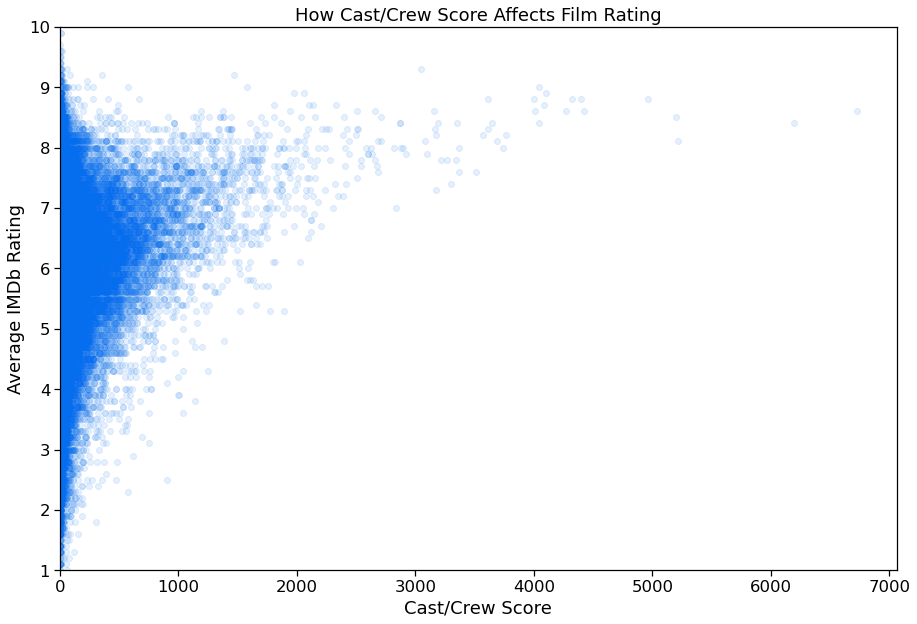

In [15]:
# Initial plot of data

plt.scatter(titles['score'], titles['averageRating'], alpha=0.1, color=color)
plt.ylim(1, 10)
plt.xlim(0)
plt.title("How Cast/Crew Score Affects Film Rating")
plt.ylabel("Average IMDb Rating")
plt.xlabel("Cast/Crew Score")

plt.show()

This graph shows far too many datapoints and does not allow for a good evaluation of a cast & crew's effect on rating. Something else needs to be done to reduce data and produce a useful model.

## Linear Regression

### Regression Prep with Binning

In [17]:
# Bin by rating. 

bins = np.arange(0, 70, 1)
bin_totals = {}

for i in bins:
    # First 0 is total of all ratings, second is bin count
    bin_totals.update({i:(0, 0)})
    
# Populate the bins with the rating totals and bin counts
for index, row in titles.iterrows():
    score_bin = math.floor(row['score']/100)
    bin_totals[score_bin] = (bin_totals.get(score_bin)[0] + row['averageRating'], bin_totals.get(score_bin)[1] + 1)

In [18]:
# Find the average rating for each bin

bin_avgs = {}
for i in bin_totals.keys():
    try:
        bin_avgs.update({i: bin_totals[i][0]/bin_totals[i][1]})
    except:
        pass

### Creating, Fitting, and Evaluating Model

In [19]:
# Create separate numpy arrays for the x and y variables. 

X = np.array([i*100 for i in list(bin_avgs.keys())[:43]]).reshape(-1, 1)
y = np.array(list(bin_avgs.values())[:43])

# Create and fit Linear Regression to data.
avg_model = LinearRegression().fit(X, y)

score = avg_model.score(X, y)
intercept = avg_model.intercept_
coef = avg_model.coef_[0]

### Plotting Bins and Model Output

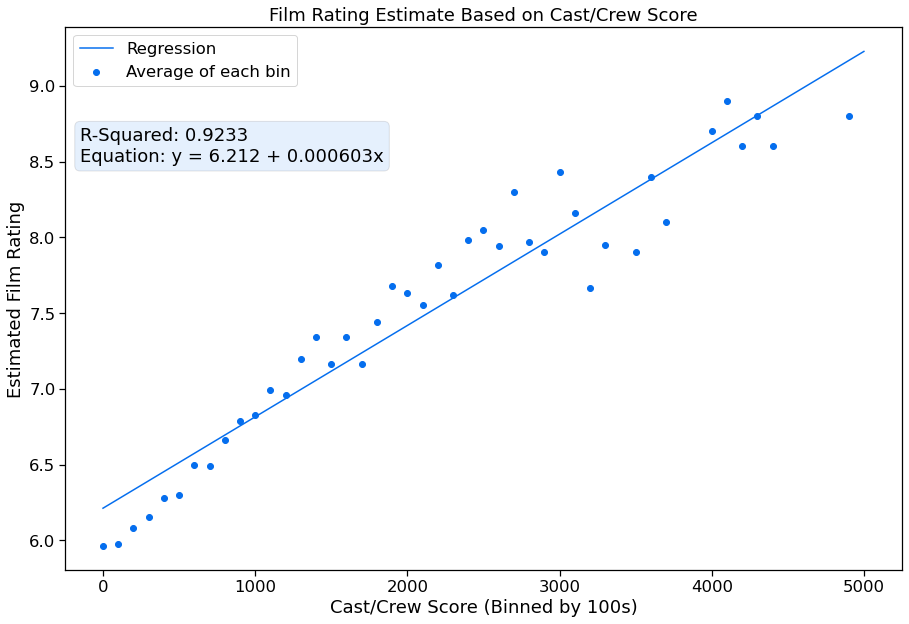

In [20]:
# Plotting Cast/Crew Score against Rating with Linear Regression

plt.scatter([i*100 for i in list(bin_avgs.keys())[:43]], list(bin_avgs.values())[:43], color=color)
plt.plot([0, 5000], [intercept+coef*0, intercept+coef*5000], color=color)
plt.title("Film Rating Estimate Based on Cast/Crew Score")
plt.ylabel("Estimated Film Rating")
plt.xlabel("Cast/Crew Score (Binned by 100s)")
plt.legend(["Regression", "Average of each bin"], loc='upper left')

props = dict(boxstyle='round', facecolor=color, alpha=0.1)
plt.text(-150, 8.5, "R-Squared: " + "{:.4}".format(score) + "\nEquation: y = " + "{:.4}".format(intercept) + " + " + "{:.4}".format(coef) + "x", bbox = props)

plt.savefig("images\\avg_rating_reg.png", bbox_inches='tight')

plt.show()

## Predicting

In [131]:
# Loading DataFrames for people

name_basics = pd.read_csv("data\\IMDb\\name.basics.tsv.gz", sep='\t', compression='gzip')
people = pd.read_csv("data\\scores\\personScores.csv")

In [133]:
# Clean and merge

people = people.drop_duplicates().reset_index(drop=True)
people = pd.merge(people, name_basics.loc[:,['nconst', 'primaryName']], on='nconst', how='left')

In [134]:
# Retreive a person's unique ID from their name

def get_nconst(name, role, people):
    selection = people[people['primaryName'] == name]
    selection = selection[selection['role'] == role]
    
    # If more than one person is found with the name, let the user decide which one is correct
    if(selection.shape[0] > 1):
        print(selection.reset_index(drop=True))
        index = int(input("Enter the index of the correct person: "))
        
        return list(selection.iloc[index]['nconst'])[0]
    elif(selection.shape[0] < 1):
        return None
    else:
        return list(selection['nconst'])[0]

In [135]:
# Generate a title's score from the given directors, writers, and actors

def generate_title_score(principals, people):
    scores = []
    roles = ['d', 'w', 'a']
    
    for i in range(len(principals)):
        for j in principals[i]:
            
            # If nconst was not provided, find it
            if(not re.compile("nm[0-9]+").match(j)):
                nconst = get_nconst(j, roles[i], people)
            else:
                nconst = j
                
            entries = people[people['nconst'] == nconst]
            
            if(entries.shape[0] == 0):
                continue
            
            if(roles[i] == 'a'):
                # Put a higher focus on actors, as the general population seems more 
                # interested in actors than writers and directors
                scores.append(list(entries[entries['role'] == roles[i]]['score'])[0]*2)
            else:
                scores.append(list(entries[entries['role'] == roles[i]]['score'])[0])
            
    title_score = np.mean(scores)
    
    return title_score

### Example Predictions and Discussion

In [136]:
directors = ["Frank Darabont"]
writers = ["Stephen King", "Frank Darabont"]
actors = ["Tim Robbins", "Morgan Freeman", "Bob Gunton"]

score = generate_title_score([directors, writers, actors], people)

print('Estimated Rating:',"{:.2f}".format(avg_model.predict([[score]])[0]))

Estimated Rating: 8.20


This prediction is based on the cast and crew of *The Shawshank Redemption*.

Actual Rating: 9.3

While the estimated rating is off by a rather large amount, it still shows the film performing better than most. This is also IMDb's highest rated film, and should be seen as an outlier. 

In [137]:
directors = ["David Fincher"]
writers = ["Jack Fincher"]
actors = ["Gary Oldman", "Amanda Seyfreid", "Lily Collins"]

score = generate_title_score([directors, writers, actors], people)

print('Estimated Rating:',"{:.2f}".format(avg_model.predict([[score]])[0]))

Estimated Rating: 7.46


This prediction is based on the cast and crew of *Mank*.

Actual Rating: 7.1

This is a fairly close prediction. *Mank* is known as one of David Fincher's lesser films, and that is likely what accounts for some of the difference between the estimated and actual ratings. 

In [138]:
directors = ["Quentin Tarantino"]
writers = ["Quentin Tarantino"]
actors = ["Leonardo DiCaprio", "Brad Pitt", "Margot Robbie"]

score = generate_title_score([directors, writers, actors], people)

print('Estimated Rating:',"{:.2f}".format(avg_model.predict([[score]])[0]))

Estimated Rating: 8.65


In [139]:
directors = ["Quentin Tarantino"]
writers = ["Quentin Tarantino"]
actors = ["Leonardo DiCaprio", "Brad Pitt", "Margot Robbie", "Margaret Qualley", "Emile Hirsch", "Timothy Olyphant"]

score = generate_title_score([directors, writers, actors], people)

print('Estimated Rating:',"{:.2f}".format(avg_model.predict([[score]])[0]))

Estimated Rating: 7.88


Both of these predictions are based on the cast and crew of *Once Upon a Time... In Hollywood*.

Actual Rating: 7.6

The differences between each of these estimates shows how supporting cast members affect the scoring system. The inclusion of just 3 supporting members dropped the rating estimate by nearly 1 full point. 

## Model Evaluation

Because of the high variation in film ratings (especially when the cast/crew score is below 1000) and the contributing factors outside of cast and crew (i.e. budget, stuido, genres, etc.), accurately predicting a film's rating with only cast and crew is likely impossible. Despite this, the model and metric created still do a decent job at describing the relationship between cast/crew and film performance. The relationship is, however, expected because of how the metric is generated. A person's score is the mean of averageRating^2*numVotes for all films they were in. A title's score is then the mean of the scores of its writers, directors, and actors/actresses. Since rating is incorporated in this metric, it should be no surprise that a higher score means a higher rating. Nonetheless, if paired with more variables, this metric may prove useful. 

## Other Exploration of Data

In [322]:
# Merging film titles with original DataFrame

basics = pd.read_csv("data\\title.basics.tsv.gz", sep='\t', compression='gzip') # Warning is expected and does not cause issues
basics = basics.loc[:,['tconst', 'primaryTitle']]
basics_merged = pd.merge(titles, basics, how='inner', on='tconst')

C:\Users\zdude\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [380]:
# Looking at films with the highest scores. 
print(basics_merged.sort_values(by='score', ascending=False).reset_index(drop=True).head(20)[['primaryTitle','score','averageRating']])

                                         primaryTitle   score  averageRating
0                                               Se7en  6725.0            8.6
1                                              WALL·E  6193.0            8.4
2                                         Gran Torino  5218.0            8.1
3                                        The Prestige  5196.0            8.5
4                                          Fight Club  4959.0            8.8
5                                        Interstellar  4423.0            8.6
6                                           Inception  4395.0            8.8
7                  Kill Bill: The Whole Bloody Affair  4322.0            8.8
8                            The Silence of the Lambs  4268.0            8.6
9       The Lord of the Rings: The Return of the King  4106.0            8.9
10              The Lord of the Rings: The Two Towers  4083.0            8.7
11                              The Dark Knight Rises  4043.0            8.4

### Score vs. NumVotes

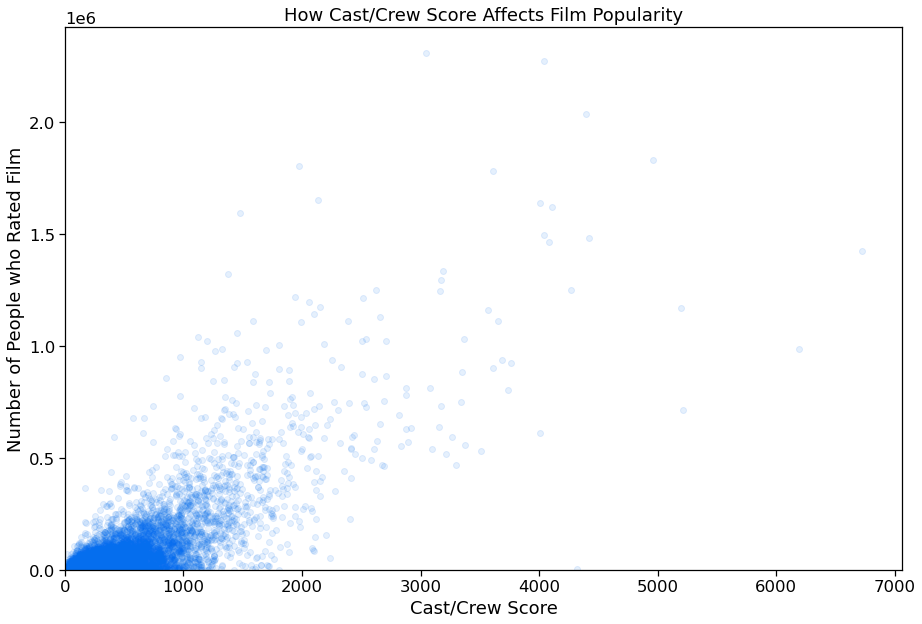

In [16]:
# Explorative plot seeing how film popularity is affected by cast & crew

plt.scatter(titles['score'], titles['numVotes'], alpha=0.1, color=color)
plt.ylim(0)
plt.xlim(0)
plt.title("How Cast/Crew Score Affects Film Popularity")
plt.ylabel("Number of People who Rated Film")
plt.xlabel("Cast/Crew Score")

plt.show()

This is not a very useful relationship. There is a general upward trend but predicting the popularity from this does not seem very realistic. A new metric with a higher focus on number of votes could be produced to help predict popularity. Genre should also be taken into account. 